In [1]:
import json
import os
from enum import Enum
from pathlib import Path

from omegaconf import OmegaConf


base_results_path = os.path.join("D:", os.sep,"Dokumente", "Git", "dal-toolbox", "baselines", "active_learning", "notebooks", "ynagel", "TimeTest")

In [2]:
# Specifying enums

class Dataset(Enum):
    CIFAR10 = "CIFAR10"
    CIFAR100 = "CIFAR100"
    SVHN = "SVHN"
    ImageNet = "IMAGENET100"

class Model(Enum):
    ResNet18 = "resnet18"
    Linear = "linear"

class Strategy(Enum):
    Random = "random"
    Entropy = "entropy"
    BADGE = "badge"
    CoreSet = "coreset"
    TypiClust = "typiclust"
    xPAL = "xpal"
    xPALClust = "xpalclust"

In [4]:
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    exp_json = path / 'results.json'
    results = load_json(exp_json)
    return results

def load_args(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    exp_cfg = path / '.hydra' / 'config.yaml'
    cfg =  OmegaConf.load(exp_cfg)
    return cfg

def get_experiments(result_path, glob_pattern):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

def create_results_path(dataset, strategy, budget, subset_size, path=base_results_path):
    return Path(os.path.join(path, dataset, strategy, f"{budget}_{subset_size}"))

path = create_results_path(Dataset.CIFAR100.value, Strategy.TypiClust.value, "10", "2500")
exp_results = get_experiments(path, 'seed*')
print(exp_results)

[{'query_times': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'query_times': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'query_times': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'query_times': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'query_times': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'query_times': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'query_times': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'query_times': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'query_times': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'query_times': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}]


In [5]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

datasets = [Dataset.CIFAR10.value, Dataset.CIFAR100.value]
strategies = [Strategy.Random.value, Strategy.BADGE.value, Strategy.TypiClust.value, Strategy.xPALClust.value, Strategy.xPAL.value]

all_exps = {}
all_exps_stds = {}

for dataset, strategy in product(datasets, strategies):
    path = create_results_path(dataset, strategy, "10", "2500")
    exp_results = get_experiments(path, 'seed*')
    mean_results = np.mean([dct["query_times"] for dct in exp_results], axis=0)
    std_results = np.std([dct["query_times"] for dct in exp_results], axis=0, ddof=1)

    all_exps[f"{dataset}_{strategy}"] = mean_results
    all_exps_stds[f"{dataset}_{strategy}"] = std_results


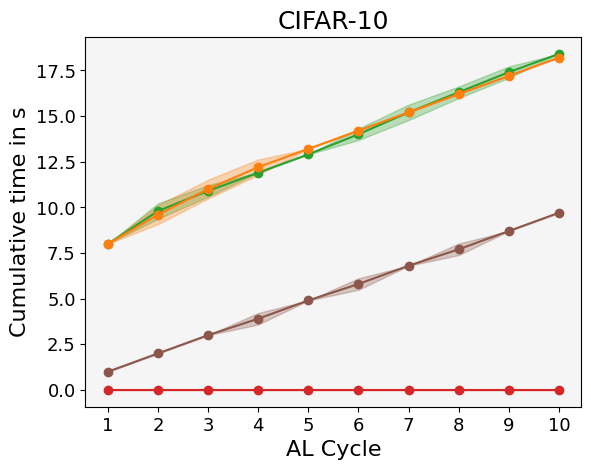

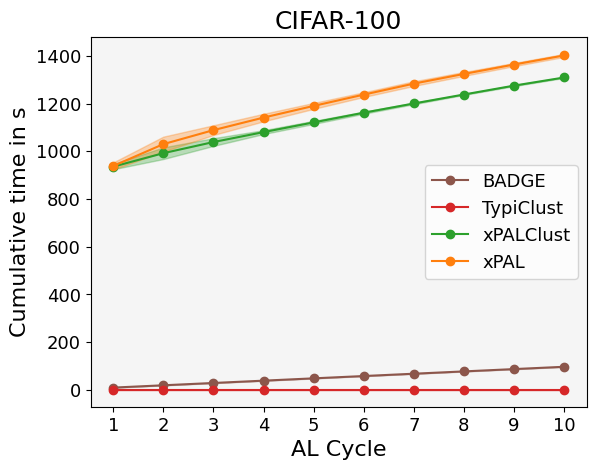

In [8]:
from matplotlib import dates

# 2500
strategy_colors = ["tab:blue", "tab:brown", "tab:red", "tab:green", "tab:orange"]
strategy_names = ["Random", "BADGE", "TypiClust", "xPALClust", "xPAL"]
dataset_names = ["CIFAR-10", "CIFAR-100"]

for dataset, dataset_name in zip(datasets, dataset_names):
    fig = plt.figure()
    ax = plt.gca()
    for strategy, color, name in zip(strategies, strategy_colors, strategy_names):
        if strategy == "random":
            continue
        exps = all_exps[f"{dataset}_{strategy}"]
        exps_stds = all_exps_stds[f"{dataset}_{strategy}"]
        y = np.cumsum(exps)

        ax.plot(y, c=color, label=name, marker="o")
        ax.fill_between(np.arange(len(exps)), y + exps_stds, y - exps_stds, color=color, alpha=0.3)
    if dataset == "CIFAR100":
        ax.legend(ncol=1, fontsize=13)
    ax.set_facecolor("whitesmoke")
    ax.set_xlabel("AL Cycle", fontsize=16)
    ax.set_ylabel("Cumulative time in s", fontsize=16)
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], size=13)
    ax.tick_params(axis='y', labelsize=13)
    plt.title(dataset_name, fontsize=18)
    plt.savefig(f"cumtime_comparison_{dataset}.pdf", bbox_inches="tight")
    plt.show()

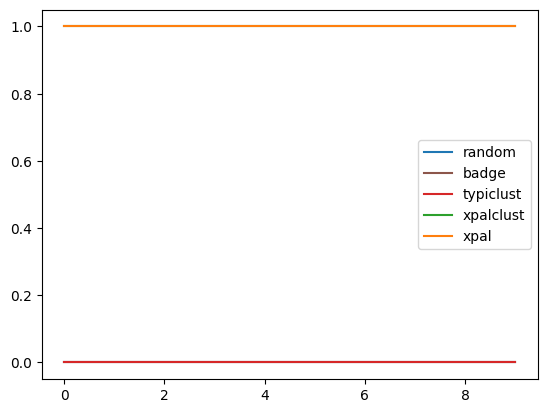

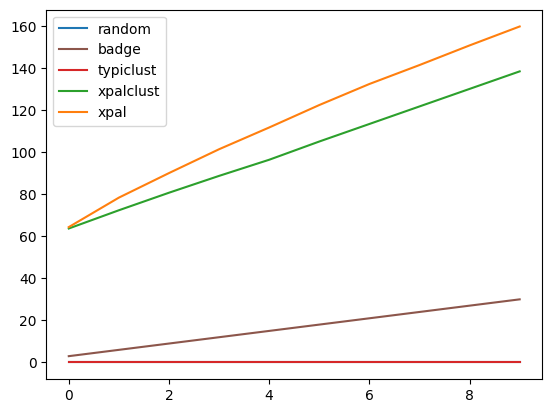

In [31]:
# 1000

strategy_colors = ["tab:blue", "tab:brown", "tab:red", "tab:green", "tab:orange"]

for dataset in datasets:
    fig = plt.figure()
    for strategy, color in zip(strategies, strategy_colors):
        exps = all_exps[f"{dataset}_{strategy}"]
        plt.plot(np.cumsum(exps), c=color, label=strategy)

    plt.legend()